In [96]:
import pickle
import sncosmo
import numpy as np
import lsst.daf.base as dafBase
import lsst.daf.persistence as dafPersist

import lsst.afw.display.ds9 as ds9

import astropy.coordinates as coord
import astropy.units as u

In [112]:
lcs = pickle.load(open('/renoir_data_02/jpreyes/lsst_data/transients4sigma_alt.lc', 'rb'))


print "there are " +str(len(lcs)) +" light curves"

there are 4029 light curves


In [113]:
i=1
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
cl = butler.get('calexp', {'visit': 850177 , 'filter':'r' , 'ccd':14})
    
wcs = cl.getWcs()
ds9.mtv(cl, frame=1)
for n, tl in enumerate(lcs):
   

    x, y = wcs.skyToPixel(tl[0]['ra'], tl[0]['dec'])
    #ds9.dot(n, x, y, frame=1, size=2)
    ds9.dot('o', x, y, frame=1, size=10, ctype=ds9.BLUE)
    i+=1
    

In [146]:
import re
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#m = re.findall('^06D3.*?\\|(.*?)\\|', data, re.MULTILINE)
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

In [115]:
import lsst.afw.geom as afwGeom
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    try:
        x, y = wcs.skyToPixel(afwGeom.Angle(c.ra.degree, afwGeom.degrees), afwGeom.Angle(c.dec.degree, afwGeom.degrees))

        ds9.dot('o', x, y, frame=1, size=25, ctype= ds9.RED)
        i+=1
    except Exception, e:
        print e

In [116]:
matches = []
for sn in elems:
    match = False
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    
    for i, lc in enumerate(lcs):
        #print lc[0]['ra']
        #print lc[0]['dec']
        if source_distance(lc[0], {'ra':c.ra.radian, 'dec':c.dec.radian}) < 2:
            match = True
 
            matches.append((sn[0], i))
            break
    
        #print 'no match'
print 'found ' + str(float(len(matches))/float(len(elems))) 

found 0.470588235294


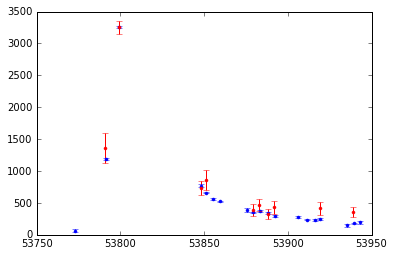

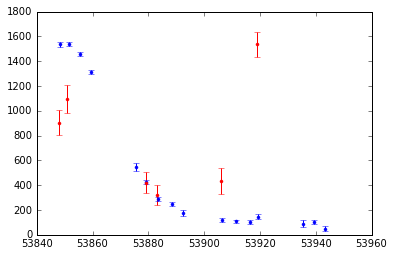

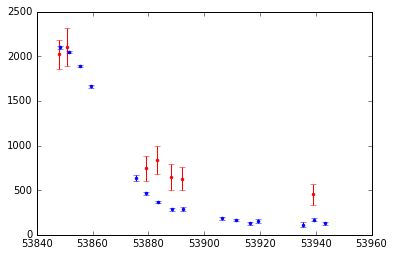

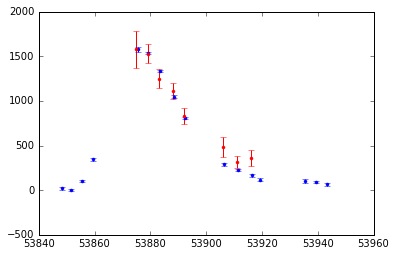

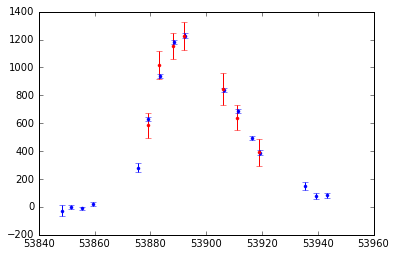

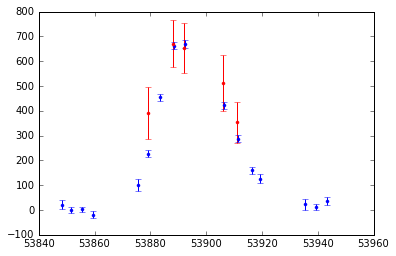

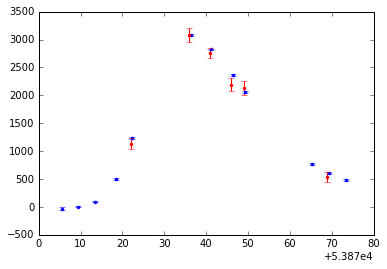

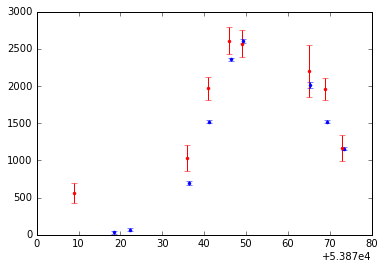

In [117]:
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()
snls_light_curves = []

for match in matches:
    
    m = re.findall('^'+str(match[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)
   
    snls_lc = build_light_curve_from_snls_file(m)
    plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    
    
    
    lc = lcs[match[-1]]   
    m_mjd, m_f, m_e = mean_lc_flux(lc)
    
    factor = max(snls_lc['flux']) / max(m_f)
    f_mf = np.multiply(m_f, factor)
    f_me = np.multiply(m_e, factor)
    
    plt.errorbar(m_mjd, f_mf, yerr=f_me, fmt='.', color='red')
    plt.show()

In [107]:
from astropy.table import Table

def source_distance(src1, src2):
    ra, dec = src1['ra'], src1['dec']
    ra2, dec2 = src2['ra'], src2['dec']
            
    return np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600

def build_light_curve_from_snls_file(data):

    bandpasses = ['r']


    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    #lightcurve['ra'] = []
    #lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for mjd, flux, error in data:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(float(mjd))
        #lightcurve['ra'].append(src['coord_ra'])
        #lightcurve['dec'].append(src['coord_dec'])
        lightcurve['flux'].append(float(flux))
        lightcurve['flux_error'].append(float(error))
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')

    lc = Table(data=lightcurve)
    return lc

def mean_lc_flux(lc2):
    mjds = []
    m_fluxes = []
    m_error = []
    i = 0
    while i < len(lc2['mjd']):
        mjd = lc2['mjd'][i]
        j = i+1
        mjds.append(int(mjd))
        m_fluxes.append(lc2['flux'][i])
        m_error.append(lc2['flux_error'][i])
        total = 1.

        while j<len(lc2['mjd']) and int(lc2['mjd'][j]) == int(mjd):

            m_fluxes[-1]+= lc2['flux'][j]
            m_error[-1] += lc2['flux_error'][j]
            #mjds[-1] += int(lc2['mjd'][j])
            total+=1
            j+=1
        m_fluxes[-1] = np.divide(m_fluxes[-1], total)
        m_error[-1] = np.divide(m_error[-1], total)
        i = j
    return mjds, m_fluxes, m_error

In [163]:
detected = []
not_detected = []
for elem in elems:
    found = False
    m = re.findall('^'+str(elem[0])+'\\|.*?\\|.*?\\|.*?\\|.*?\\|.*?\\|(.*?)\\|.*?$', data_elems, re.MULTILINE)
    
    for match in matches:
        if match[0] == elem[0]:
            detected.append(float(m[0]))
            found = True
            break
    if found == False:
        not_detected.append(float(m[0]))
    
     

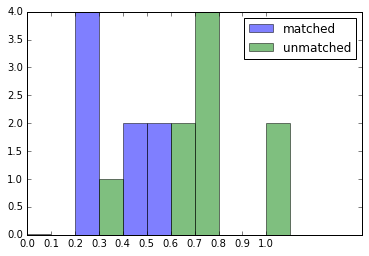

In [210]:

1.1/0.1
binwidth = 0.1
plt.hist(detected, bins=np.arange(0.0,1.1+binwidth,binwidth), alpha=0.5, label="matched")
plt.hist(not_detected, bins=np.arange(0.0,1.1+binwidth,binwidth), alpha=0.5, label='unmatched')
plt.xticks(np.arange(0.0, 1.1, 0.1))

#plt.xlim(xmin=0, xmax=1.1)
plt.legend(loc='upper right')
plt.show()